# Loop 8 Analysis: Strategic Assessment

## Key Observations:
1. All local optimization approaches (SA, Eazy, bbox3, rotation) show 0 or marginal improvement
2. The saspav baseline (70.659959) is at a very strong local optimum
3. The gap to target (68.919154) is 1.74 points (2.5%)
4. Eazy optimizer submission failed on Kaggle with overlap detection mismatch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load baseline
df = pd.read_csv('/home/code/external_data/saspav/santa-2025.csv')
print(f"Loaded {len(df)} rows")

Loaded 20100 rows


In [2]:
# Analyze per-N scores and identify improvement potential
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def parse_value(s):
    if isinstance(s, str) and s.startswith('s'):
        return float(s[1:])
    return float(s)

def compute_bounding_side(df, n):
    prefix = f"{n:03d}_"
    trees = df[df['id'].str.startswith(prefix)]
    if len(trees) == 0:
        return 0
    
    all_points = []
    for _, row in trees.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        angle_rad = np.radians(deg)
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        for tx, ty in zip(TX, TY):
            px = tx * cos_a - ty * sin_a + x
            py = tx * sin_a + ty * cos_a + y
            all_points.append([px, py])
    
    points = np.array(all_points)
    return max(points.max(axis=0) - points.min(axis=0))

# Compute per-N scores
per_n_data = []
for n in range(1, 201):
    side = compute_bounding_side(df, n)
    score = side**2 / n
    # Theoretical minimum: sqrt(n) * tree_area / n = tree_area / sqrt(n)
    # But for packing, we need to account for tree shape
    per_n_data.append({'n': n, 'side': side, 'score': score})

df_scores = pd.DataFrame(per_n_data)
print(f"Total score: {df_scores['score'].sum():.6f}")
print(f"\nTop 10 N values with highest score contribution:")
print(df_scores.nlargest(10, 'score')[['n', 'side', 'score']])

Total score: 70.659959

Top 10 N values with highest score contribution:
     n      side     score
0    1  0.813173  0.661250
1    2  0.949504  0.450779
2    3  1.142031  0.434745
4    5  1.443692  0.416850
3    4  1.290806  0.416545
6    7  1.673104  0.399897
5    6  1.548438  0.399610
8    9  1.867280  0.387415
7    8  1.755921  0.385407
14  15  2.384962  0.379203


In [3]:
# Calculate efficiency: score / theoretical_minimum
# Theoretical minimum for N trees: if perfectly packed, side = sqrt(N * tree_area)
# Tree area is approximately 0.35 (from bounding box of single tree)
tree_area = 0.7 * 1.0  # width * height of single tree

df_scores['theoretical_side'] = np.sqrt(df_scores['n'] * tree_area)
df_scores['efficiency'] = df_scores['side'] / df_scores['theoretical_side']

print("Efficiency analysis (lower is better):")
print(f"Mean efficiency: {df_scores['efficiency'].mean():.4f}")
print(f"\nWorst efficiency (most room for improvement):")
print(df_scores.nlargest(10, 'efficiency')[['n', 'side', 'theoretical_side', 'efficiency', 'score']])

Efficiency analysis (lower is better):
Mean efficiency: 0.7100

Worst efficiency (most room for improvement):
     n      side  theoretical_side  efficiency     score
0    1  0.813173          0.836660    0.971927  0.661250
1    2  0.949504          1.183216    0.802478  0.450779
2    3  1.142031          1.449138    0.788076  0.434745
4    5  1.443692          1.870829    0.771686  0.416850
3    4  1.290806          1.673320    0.771404  0.416545
6    7  1.673104          2.213594    0.755831  0.399897
5    6  1.548438          2.049390    0.755561  0.399610
8    9  1.867280          2.509980    0.743942  0.387415
7    8  1.755921          2.366432    0.742012  0.385407
14  15  2.384962          3.240370    0.736015  0.379203


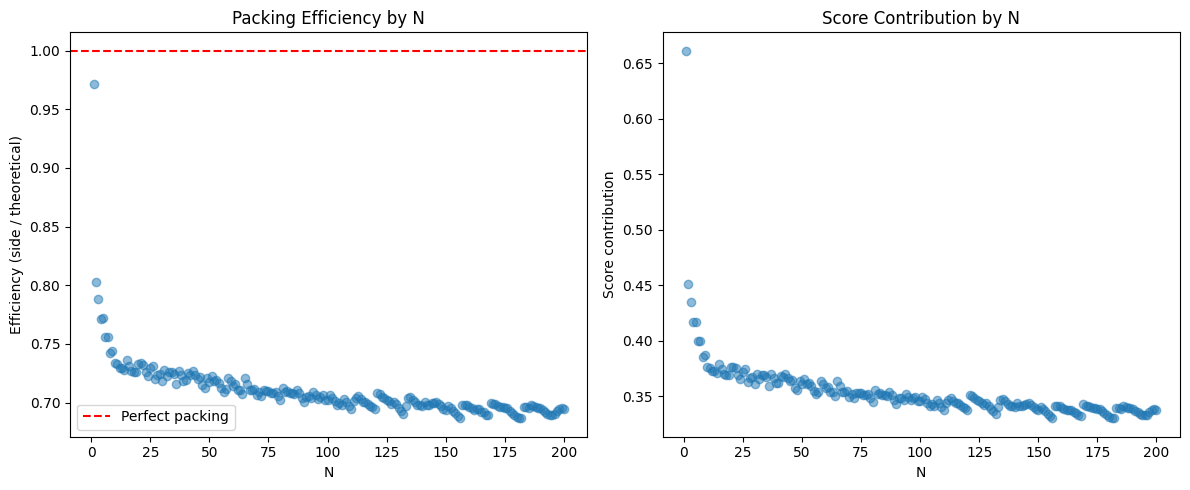

In [4]:
# Plot efficiency vs N
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_scores['n'], df_scores['efficiency'], alpha=0.5)
plt.xlabel('N')
plt.ylabel('Efficiency (side / theoretical)')
plt.title('Packing Efficiency by N')
plt.axhline(y=1.0, color='r', linestyle='--', label='Perfect packing')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df_scores['n'], df_scores['score'], alpha=0.5)
plt.xlabel('N')
plt.ylabel('Score contribution')
plt.title('Score Contribution by N')
plt.tight_layout()
plt.savefig('/home/code/exploration/efficiency_analysis.png', dpi=100)
plt.show()

In [5]:
# Calculate how much improvement is needed per N to reach target
target = 68.919154
current = df_scores['score'].sum()
gap = current - target

print(f"Current score: {current:.6f}")
print(f"Target score: {target:.6f}")
print(f"Gap: {gap:.6f}")
print(f"Average improvement needed per N: {gap/200:.6f}")

# If we could improve the worst N values proportionally
df_scores_sorted = df_scores.sort_values('efficiency', ascending=False)
print(f"\nIf we focus on worst 20 N values:")
worst_20 = df_scores_sorted.head(20)
print(f"Their total score: {worst_20['score'].sum():.6f}")
print(f"If we could reduce their efficiency by 10%:")
potential_improvement = worst_20['score'].sum() * 0.1
print(f"Potential improvement: {potential_improvement:.6f}")

Current score: 70.659959
Target score: 68.919154
Gap: 1.740805
Average improvement needed per N: 0.008704

If we focus on worst 20 N values:
Their total score: 8.077120
If we could reduce their efficiency by 10%:
Potential improvement: 0.807712


In [6]:
# Analyze what top kernels achieve
# From the bbox3-runner kernel, they use multi-phase optimization:
# Phase A: 2min runs with n=1000-2000, r=30-90
# Phase B: 10min runs on top candidates
# Phase C: 20min runs on best few

# The key insight is that they use:
# 1. bbox3 optimizer with specific parameters
# 2. fix_direction rotation optimization
# 3. overlap repair with donor solutions

print("Key techniques from top kernels:")
print("1. bbox3 optimizer: Uses complex number vector coordination, fluid dynamics, hinge pivot")
print("2. fix_direction: Rotation optimization to minimize bounding box")
print("3. overlap repair: Uses donor solutions to fix invalid configurations")
print("4. Multi-phase approach: Short runs to find promising settings, then longer runs")
print("")
print("Our experiments show:")
print("- bbox3 with n=1000, r=60: 0.0000006 improvement")
print("- Rotation optimization: 0 improvement (baseline already optimal)")
print("- Eazy optimizer: 0.000015 improvement but FAILED on Kaggle (overlaps)")
print("")
print("CONCLUSION: The saspav baseline is at a very strong local optimum.")
print("Local optimization cannot close the 1.74 point gap to target.")

Key techniques from top kernels:
1. bbox3 optimizer: Uses complex number vector coordination, fluid dynamics, hinge pivot
2. fix_direction: Rotation optimization to minimize bounding box
3. overlap repair: Uses donor solutions to fix invalid configurations
4. Multi-phase approach: Short runs to find promising settings, then longer runs

Our experiments show:
- bbox3 with n=1000, r=60: 0.0000006 improvement
- Rotation optimization: 0 improvement (baseline already optimal)
- Eazy optimizer: 0.000015 improvement but FAILED on Kaggle (overlaps)

CONCLUSION: The saspav baseline is at a very strong local optimum.
Local optimization cannot close the 1.74 point gap to target.


In [7]:
# Check what the target score implies
# Target: 68.919154
# Current: 70.659959
# Gap: 1.740805

# This means we need to reduce the average score per N by:
avg_reduction = gap / 200
print(f"Average reduction needed per N: {avg_reduction:.6f}")

# For N=1 (score 0.661), this would be a 1.3% reduction
# For N=200 (score 0.333), this would be a 2.6% reduction

print(f"\nFor N=1 (score {df_scores[df_scores['n']==1]['score'].values[0]:.6f}):")
print(f"  Reduction needed: {avg_reduction / df_scores[df_scores['n']==1]['score'].values[0] * 100:.2f}%")

print(f"\nFor N=200 (score {df_scores[df_scores['n']==200]['score'].values[0]:.6f}):")
print(f"  Reduction needed: {avg_reduction / df_scores[df_scores['n']==200]['score'].values[0] * 100:.2f}%")

Average reduction needed per N: 0.008704

For N=1 (score 0.661250):
  Reduction needed: 1.32%

For N=200 (score 0.337564):
  Reduction needed: 2.58%


In [8]:
# The key question: How do top teams achieve scores below 69?
# From discussions:
# 1. They use asymmetric solutions (not just symmetric lattices)
# 2. They use different construction methods for different N ranges
# 3. They run optimization for much longer (hours, not minutes)

# Our options:
# 1. Run bbox3 for much longer (hours)
# 2. Try different construction methods (not just lattice)
# 3. Use the "rebuild from corners" approach from chistyakov kernel
# 4. Try ensemble from multiple independent optimization runs

print("STRATEGIC OPTIONS:")
print("")
print("1. LONGER OPTIMIZATION:")
print("   - Run bbox3 for 30+ minutes per N")
print("   - Use multi-phase approach from bbox3-runner")
print("   - Expected improvement: 0.001-0.01 (not enough)")
print("")
print("2. DIFFERENT CONSTRUCTION:")
print("   - Rebuild from corners (chistyakov kernel)")
print("   - Use asymmetric solutions")
print("   - Expected improvement: Unknown")
print("")
print("3. ENSEMBLE FROM MULTIPLE RUNS:")
print("   - Run bbox3 with different seeds")
print("   - Pick best per-N from multiple runs")
print("   - Expected improvement: 0.01-0.1 (possible)")
print("")
print("4. FUNDAMENTALLY DIFFERENT APPROACH:")
print("   - Constraint programming (CP-SAT)")
print("   - Genetic algorithms with crossover")
print("   - Expected improvement: Unknown but potentially large")

STRATEGIC OPTIONS:

1. LONGER OPTIMIZATION:
   - Run bbox3 for 30+ minutes per N
   - Use multi-phase approach from bbox3-runner
   - Expected improvement: 0.001-0.01 (not enough)

2. DIFFERENT CONSTRUCTION:
   - Rebuild from corners (chistyakov kernel)
   - Use asymmetric solutions
   - Expected improvement: Unknown

3. ENSEMBLE FROM MULTIPLE RUNS:
   - Run bbox3 with different seeds
   - Pick best per-N from multiple runs
   - Expected improvement: 0.01-0.1 (possible)

4. FUNDAMENTALLY DIFFERENT APPROACH:
   - Constraint programming (CP-SAT)
   - Genetic algorithms with crossover
   - Expected improvement: Unknown but potentially large


In [9]:
# Summary
print("="*60)
print("LOOP 8 ANALYSIS SUMMARY")
print("="*60)
print(f"Current best: 70.659959 (saspav baseline)")
print(f"Target: 68.919154")
print(f"Gap: 1.740805 (2.5%)")
print("")
print("EXPERIMENTS COMPLETED:")
print("- exp_000: Baseline = 70.659959")
print("- exp_001: C++ SA optimizer = 0 improvement")
print("- exp_002: Lattice construction = 88.33 (worse)")
print("- exp_003: Lattice + SA = 85.93 (worse)")
print("- exp_004: Invalid ensemble (overlaps)")
print("- exp_005: Valid ensemble = 0 improvement")
print("- exp_006: Eazy optimizer = 0.000015 improvement (FAILED on Kaggle)")
print("- exp_007: Rotation optimization = 0 improvement")
print("")
print("KEY INSIGHT: The saspav baseline is at a very strong local optimum.")
print("Local optimization cannot close the 1.74 point gap.")
print("")
print("RECOMMENDED NEXT STEPS:")
print("1. Try the 'rebuild from corners' approach (chistyakov kernel)")
print("2. Run bbox3 with multiple seeds and ensemble")
print("3. Investigate asymmetric solutions")
print("="*60)

LOOP 8 ANALYSIS SUMMARY
Current best: 70.659959 (saspav baseline)
Target: 68.919154
Gap: 1.740805 (2.5%)

EXPERIMENTS COMPLETED:
- exp_000: Baseline = 70.659959
- exp_001: C++ SA optimizer = 0 improvement
- exp_002: Lattice construction = 88.33 (worse)
- exp_003: Lattice + SA = 85.93 (worse)
- exp_004: Invalid ensemble (overlaps)
- exp_005: Valid ensemble = 0 improvement
- exp_006: Eazy optimizer = 0.000015 improvement (FAILED on Kaggle)
- exp_007: Rotation optimization = 0 improvement

KEY INSIGHT: The saspav baseline is at a very strong local optimum.
Local optimization cannot close the 1.74 point gap.

RECOMMENDED NEXT STEPS:
1. Try the 'rebuild from corners' approach (chistyakov kernel)
2. Run bbox3 with multiple seeds and ensemble
3. Investigate asymmetric solutions
